In [1]:
%load_ext autotime

!nvidia-smi -L

import os

os.environ['CUDA_VISIBLE_DEVICES']='0'

GPU 0: NVIDIA GeForce RTX 3090 (UUID: GPU-3b49e2b8-87f0-c515-798b-3492ec05a183)
GPU 1: NVIDIA GeForce GTX 1080 Ti (UUID: GPU-07628ed7-6ef8-fd67-7d03-cb6a89f72de4)


In [2]:
# process xml files and make gray image masks from them

# %run -i utils.py 

In [3]:
import tensorflow as tf , numpy as np, matplotlib.pyplot as plt, glob
from tensorflow import keras
import tensorflow.keras.backend as K
from tqdm.notebook import tqdm
from PIL import Image

In [4]:
tf.config.get_visible_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [5]:
train_img_path = "./data/MoNuSeg 2018 Training Data/Tissue Images/"
train_mask_path = "./data/MoNuSeg 2018 Training Data/Masks/"

test_img_path = "./data/MoNuSegTestData/"
test_mask_path = "./data/MoNuSegTestData/Masks/"

train_img_files = sorted(glob.glob(train_img_path+"*.tif"))
train_mask_files = sorted(glob.glob(train_mask_path+"*.png"))

test_img_files = sorted(glob.glob(test_img_path+"*.tif"))
test_mask_files = sorted(glob.glob(test_mask_path+"*.png"))

In [6]:
# Add (12, 12) pad so Images get (1024, 1024) in size

def img_load(files_path, mask=False):
  res = []
  for img in tqdm(files_path, total=len(files_path)):
    im = Image.open(img)
    im = np.array(im)
    if mask:
      im_padded = np.pad(im, ((12, 12), (12, 12)), constant_values=0)
    else:
      im_padded = np.pad(im, ((12, 12), (12, 12), (0, 0)), constant_values=0)
    res.append(im_padded)
    
  return np.array(res)

In [7]:
train_images = img_load(train_img_files)
train_masks = img_load(train_mask_files, mask=True)
train_masks = np.expand_dims(train_masks, -1)

test_images = img_load(test_img_files)
test_masks = img_load(test_mask_files, mask=True)
test_masks = np.expand_dims(test_masks, -1)

print(train_images.shape, train_masks.shape)
print(test_images.shape, test_masks.shape)

  0%|          | 0/37 [00:00<?, ?it/s]

  0%|          | 0/37 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

(37, 1024, 1024, 3) (37, 1024, 1024, 1)
(14, 1024, 1024, 3) (14, 1024, 1024, 1)


In [8]:
X_train = train_images[:30]
Y_train = train_masks[:30] / 255.
X_valid = train_images[30:]
Y_valid = train_masks[30:]  / 255.
print(X_train.shape, Y_train.shape)
print(X_valid.shape, Y_valid.shape)
X_train.max(), X_train.min() # so it's just need a rescale

(30, 1024, 1024, 3) (30, 1024, 1024, 1)
(7, 1024, 1024, 3) (7, 1024, 1024, 1)


(255, 0)

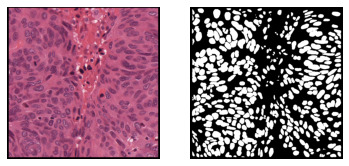

In [9]:
im_p = Image.fromarray(X_train[0])
# im_lp = Image.fromarray((Y_train_patched[0]*255).astype(np.uint8))
plt.subplot(1, 2, 1)
plt.imshow(im_p);
plt.axis('off')
plt.subplot(1, 2, 2)
plt.imshow((Y_train[0]*255).astype(np.uint8), cmap='gray');
plt.axis('off');

In [10]:
keras.backend.clear_session()
filters = 32

inputs = keras.layers.Input(X_train[0].shape)
x = keras.layers.Rescaling(1./255)(inputs)
x = keras.layers.Conv2D(filters, 3, strides=2, activation='relu', padding='same')(x)
x = keras.layers.Conv2D(filters, 3, activation='relu', padding='same')(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Conv2D(filters*2, 3, strides=2, activation='relu', padding='same')(x)
x = keras.layers.Conv2D(filters*2, 3, activation='relu', padding='same')(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Conv2D(filters*4, 3, strides=2, activation='relu', padding='same')(x)
x = keras.layers.Conv2D(filters*4, 3, activation='relu', padding='same')(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Conv2D(filters*8, 3, strides=2, activation='relu', padding='same')(x)
x = keras.layers.Conv2D(filters*8, 3, activation='relu', padding='same')(x)
x = keras.layers.BatchNormalization()(x)

x = keras.layers.Conv2DTranspose(filters*8, 3, activation='relu', padding='same')(x)
x = keras.layers.Conv2DTranspose(filters*8, 3, strides=2, activation='relu', padding='same')(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Conv2DTranspose(filters*4, 3, activation='relu', padding='same')(x)
x = keras.layers.Conv2DTranspose(filters*4, 3, strides=2, activation='relu', padding='same')(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Conv2DTranspose(filters*2, 3, activation='relu', padding='same')(x)
x = keras.layers.Conv2DTranspose(filters*2, 3, strides=2, activation='relu', padding='same')(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Conv2DTranspose(filters, 3, activation='relu', padding='same')(x)
x = keras.layers.Conv2DTranspose(filters, 3, strides=2, activation='relu', padding='same')(x)
x = keras.layers.BatchNormalization()(x)

output = keras.layers.Conv2D(1, 3, activation='sigmoid', padding='same')(x)

model = keras.Model(inputs=inputs, outputs=output)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1024, 1024, 3)]   0         
                                                                 
 rescaling (Rescaling)       (None, 1024, 1024, 3)     0         
                                                                 
 conv2d (Conv2D)             (None, 512, 512, 32)      896       
                                                                 
 conv2d_1 (Conv2D)           (None, 512, 512, 32)      9248      
                                                                 
 batch_normalization (BatchN  (None, 512, 512, 32)     128       
 ormalization)                                                   
                                                                 
 conv2d_2 (Conv2D)           (None, 256, 256, 64)      18496     
                                                             

In [11]:
train_ds = tf.data.Dataset.from_tensor_slices((X_train, Y_train)).batch(8).shuffle(16).prefetch(16)
val_ds = tf.data.Dataset.from_tensor_slices((X_valid, Y_valid)).batch(8).shuffle(16).prefetch(16)

In [12]:
def iou(y_true, y_pred, smooth=1.):
    y_true = K.flatten(y_true)
    y_pred = K.flatten(y_pred)
    intersection = K.sum(y_true * y_pred)
    res = (intersection + smooth) / (K.sum(y_true) + K.sum(y_pred) - intersection + smooth)
    
    return res

In [13]:
model.compile(
  optimizer = 'rmsprop',
  loss='binary_crossentropy',
  metrics = [iou]
)

In [14]:
callbacks = [
  keras.callbacks.ModelCheckpoint(
    "./checkpoints/MoNuSeg2018-base.h5",
    save_best_only=True
  )
]

In [15]:
h = model.fit(train_ds, epochs=30, validation_data=val_ds, callbacks=callbacks)

Epoch 1/30
4/4 [==============================] - 12s 2s/step - loss: 0.7799 - iou: 0.1803 - val_loss: 0.6690 - val_iou: 0.2300
Epoch 2/30
4/4 [==============================] - 1s 269ms/step - loss: 0.6953 - iou: 0.1774 - val_loss: 0.6754 - val_iou: 0.2431
Epoch 3/30
4/4 [==============================] - 1s 267ms/step - loss: 0.6596 - iou: 0.1748 - val_loss: 0.6697 - val_iou: 0.2401
Epoch 4/30
4/4 [==============================] - 1s 345ms/step - loss: 0.6462 - iou: 0.1733 - val_loss: 0.6641 - val_iou: 0.2368
Epoch 5/30
4/4 [==============================] - 1s 329ms/step - loss: 0.6319 - iou: 0.1720 - val_loss: 0.6588 - val_iou: 0.2333
Epoch 6/30
4/4 [==============================] - 1s 326ms/step - loss: 0.6154 - iou: 0.1769 - val_loss: 0.6548 - val_iou: 0.2304
Epoch 7/30
4/4 [==============================] - 1s 354ms/step - loss: 0.5887 - iou: 0.1839 - val_loss: 0.6440 - val_iou: 0.2223
Epoch 8/30
4/4 [==============================] - 1s 349ms/step - loss: 0.5711 - iou: 0.1945

1/1 [==============================] - 1s 843ms/step


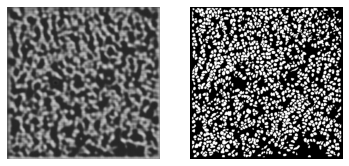

In [16]:
model = keras.models.load_model("./checkpoints/MoNuSeg2018-base.h5", custom_objects={'iou':iou})

pred = model.predict(np.expand_dims(X_valid[0], 0))

plt.subplot(1, 2, 1)
plt.imshow((pred[0]*255), cmap='gray');
plt.axis('off')
plt.subplot(1, 2, 2)
plt.imshow((Y_valid[0]*255), cmap='gray');
plt.axis('off');

1/1 [==============================] - 0s 238ms/step


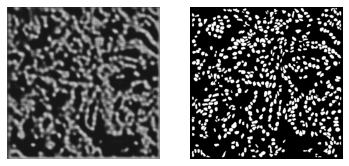

In [17]:
model = keras.models.load_model("./checkpoints/MoNuSeg2018-base.h5", custom_objects={'iou':iou})

pred = model.predict(np.expand_dims(test_images[0], 0))

plt.subplot(1, 2, 1)
plt.imshow((pred[0]*255), cmap='gray');
plt.axis('off')
plt.subplot(1, 2, 2)
plt.imshow((test_masks[0]), cmap='gray');
plt.axis('off');